# Stock Price Prediction

## Project Overview:

A stock market is the aggregation of buyers and sellers of stocks, when people talks stocks, they are usually talking
about companies listed on major stock exchanges like the New York Stock Exchange (NYSE) , the Nasdaq,
the Bombay Stock Exchange (BSE) and many others where stockbrokers and traders can buy and
sell shares of stock which represents ownership/share claims on businesses.
When we buy a stock of a company and if that company does good then it’s more likely that stock price goes up
and we gain the same percentage of profit in the investment of that stock and vice versa .
Stock market prediction has been one of the challenges for researchers and financial investors, over the years they
have been trying to better understand stock price behavior and make profitable investments and trades.
However, predicting stock market movements is extremely challenging because according to Zhong and Enke
(2017), stock markets are affected by many highly interrelated factors that include economic, political,
psychological, and company-specific variables.

Stock market price prediction is a tricky thing. Several theories regarding stock markets have been conceptualized
over the years. One is Efficient Market Hypothesis (EMH) and another one is Random Walk Theory.

**Efficient Market Hypothesis (EMH)**: It states that at any point of time, the market price of a stock incorporates all
information about that stock. Hence it is not possible to outperform the stock market.

**Random walk theory**: Random walk theory assumes that it is impossible to predict stock prices as stock prices
don't depend on past stock. It also considers that stock price has great fluctuations, so it is infeasible to predict
future stock prices.

Many widely accepted empirical studies show that financial markets are to some extent predictable (Chong et al.
2017). Criticism of EMH has given rise to an increasing number of studies that question the validity of EMH and
introduce new and successful approaches that combine technical analysis indicators and chart patterns with
methodologies from econometrics, statistics, data mining, and artificial intelligence (Arévalo et al. 2017).

I have been doing stock trading for last couple of years and analyzing stock market behavior fascinates me a lot.
Being an active stock trader motivates me to utilize all my technical and functional skills to build the stock market
predictor, so that I can utilize this predictor for my stock trading. I believe it will be a perfect project to evaluate my
final model with real time stock data which can help me to optimize this predictor over period.

## Problem Statement:

The Market researchers and financial investors have been facing the problem of not being able to predict stock
market price movement, hence they are struggling to make profitable investments and trades.

In this project, I will be building a stock price predictor that takes daily trading data for a list of ticker symbols (e.g.
TSLA, FB) over a last 5 years span as input, and outputs the predicted stock prices for each of those stocks on
the given dates.

## Metrics:

I will use Root Mean Square Error (RMSE) as the evaluation metric which is very popular evaluation metrics for
regression problems, it is a frequently used measure of the differences between values (sample or population
values) predicted by a model or an estimator and the values observed.

I will compare RMSE value for Amazon SageMaker DeepAR forecasting algorithm against my benchmark model,also I will implement and validate Long short term memory (LSTM). 

In this comparison whichever model will have lower RMSE value that will have the best accuracy among them, hence I will choose the model with lower RMSE as my best model.

## Data Exploration :

For this project, I will use historical stock data of top 10 stocks holdings of ARK Next Generation Internet ETF
(ARKW) ETF from **Yahoo! Finance** using [rapidapi](https://rapidapi.com/apidojo/api/yahoo-finance1) for last 5 years (Jul 12, 2015 - Jul 12, 2020).

#### Import modules:

In [1]:
import numpy as np
import pandas as pd
import json
import time
from datetime import datetime
from requests import request
import matplotlib.pyplot as plt

In [2]:
#Sagemaker resources

import boto3
import sagemaker
from sagemaker import get_execution_role
import os
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

In [3]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()

In [4]:
# save this data to a local directory
data_dir = 'json_stock_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [5]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

In [6]:
# general prefix
prefix='deepar-stock-prediction'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

#### Load Data: 

I will use **rapidapi** api call to get historical stock data of top 10 stocks holdings of ARK Next Generation Internet ETF (ARKW) ETF.

In [7]:
def load_stock_data(freq, start, end, symbol):
    url = 'https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-historical-data'
    
    query_string = {'frequency':freq,
                    'filter':'history',
                    'period1':start,
                    'period2':end,
                    'symbol':symbol
                   }
    
    headers = {'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com", # ENTER INFO HERE
               'x-rapidapi-key': "794f03d726msh91a48550b9c26e5p11e6eajsn032b3dc2a825" # ENTER INFO HERE
              }
    
    response = request('GET', url, headers=headers, params=query_string)
    
    return response

In [8]:
start_date = '01/01/2015'
end_date = datetime.now()

start_timestamp = int(time.mktime(datetime.strptime(start_date, '%m/%d/%Y').timetuple()))
end_timestamp = int(datetime.timestamp(end_date))

data = []
stock_tickers = ['TSLA' ,'SQ','ROKU','TWOU','Z','SPLK', 'TREE','PINS','XLNX','FB']
for ticker in stock_tickers:
    data.append(load_stock_data('1d', start_timestamp, end_timestamp, ticker))

In [9]:
data

[<Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>]

###### "data" object has 10 time series of each stocks and this time series is in reverse chronological order which needs to be reversed.
For prediction we will be using stock adjusted price and date for each days.

In [10]:
stock_data = [json.loads(d.text)['prices'] for d in data]

In [11]:
stock_data[1][1]

{'date': 1596547800,
 'open': 135.8800048828125,
 'high': 137.8000030517578,
 'low': 133.60000610351562,
 'close': 136.8300018310547,
 'volume': 10298900,
 'adjclose': 136.8300018310547}

In [12]:
time_series = []
for stock in stock_data:
    values = []
    index = []
    for day in stock:
        if 'adjclose' in day:
            values.append(day['adjclose'])
            index.append(datetime.fromtimestamp(day['date']))
    values.reverse()
    index.reverse()
    time_series.append(pd.Series(data=values, index=index))
    print(len(values))

1408
1185
718
1408
1262
1408
1408
328
1408
1408


In [13]:
type(time_series)

list

In [14]:
time_series[0]

2015-01-02 14:30:00     219.309998
2015-01-05 14:30:00     210.089996
2015-01-06 14:30:00     211.279999
2015-01-07 14:30:00     210.949997
2015-01-08 14:30:00     210.619995
                          ...     
2020-07-30 13:30:00    1487.489990
2020-07-31 13:30:00    1430.760010
2020-08-03 13:30:00    1485.000000
2020-08-04 13:30:00    1487.000000
2020-08-05 20:00:01    1485.020020
Length: 1408, dtype: float64

## Exploratory Visualization:


##### Using this time series we will visualize each stocks and their patterns

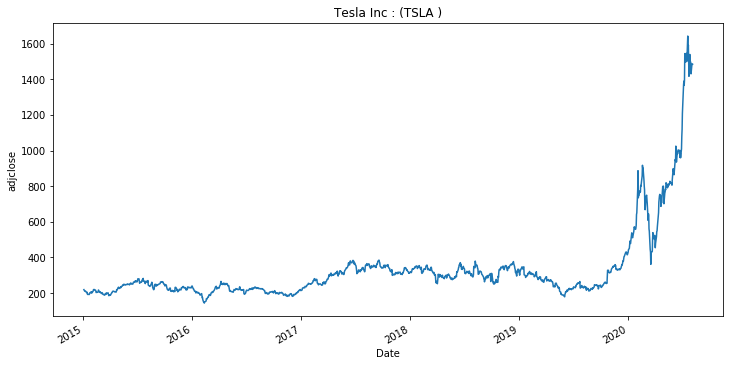

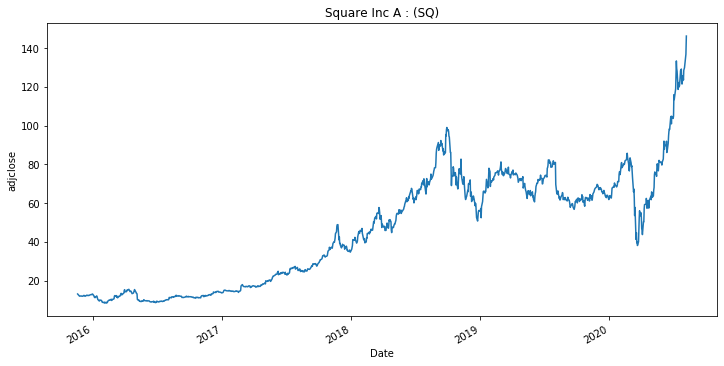

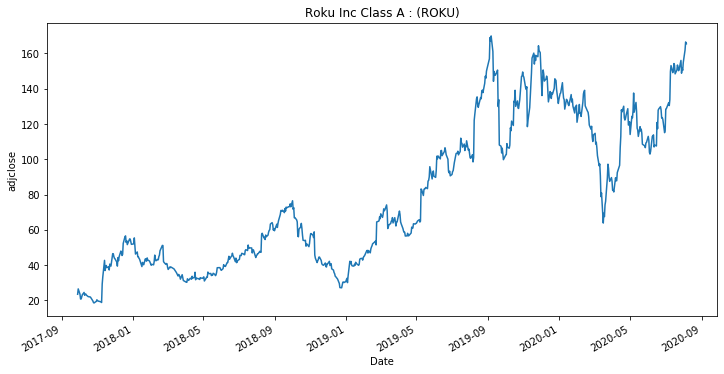

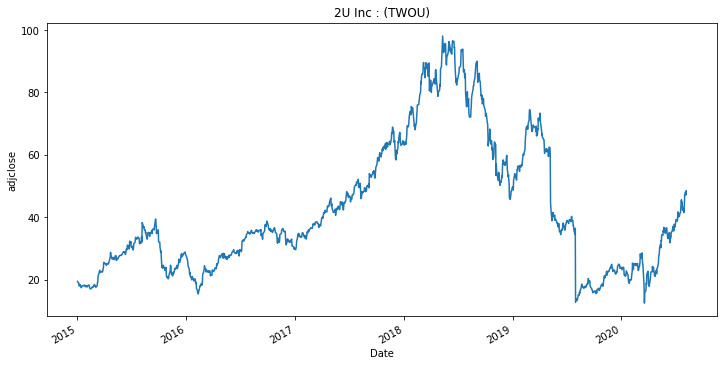

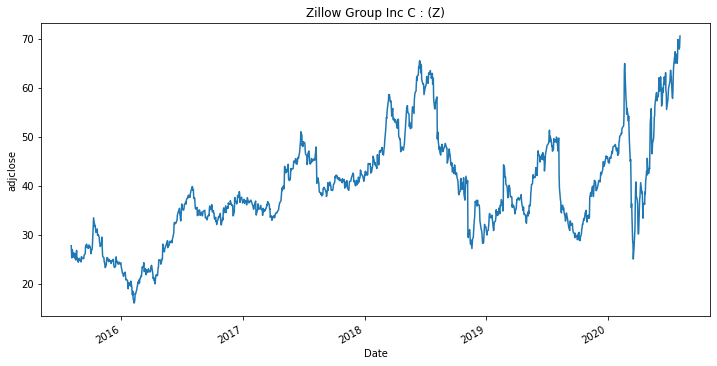

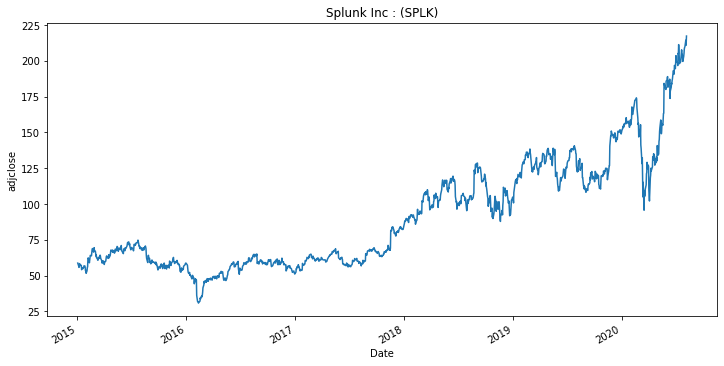

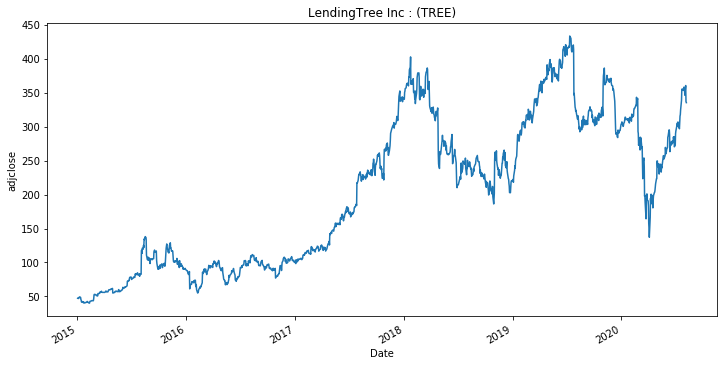

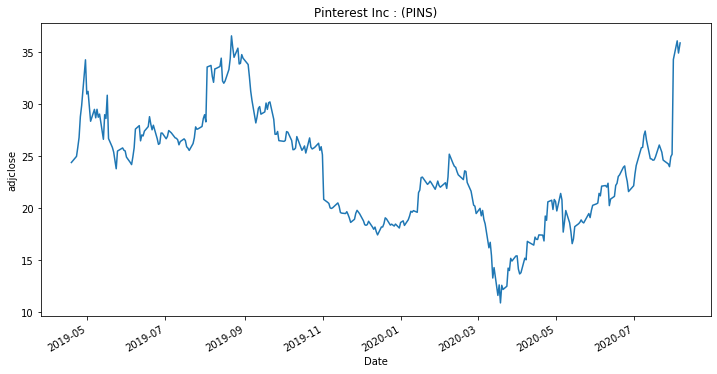

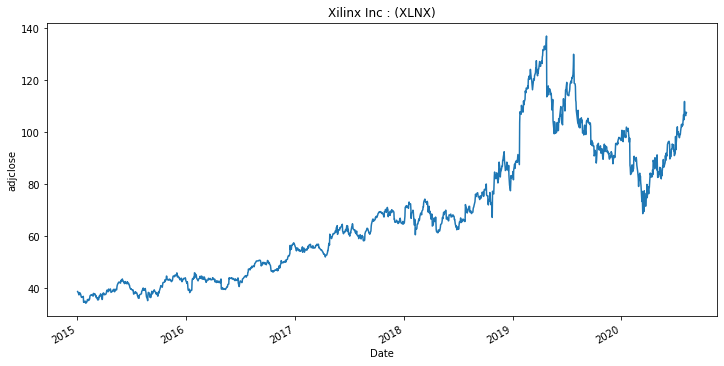

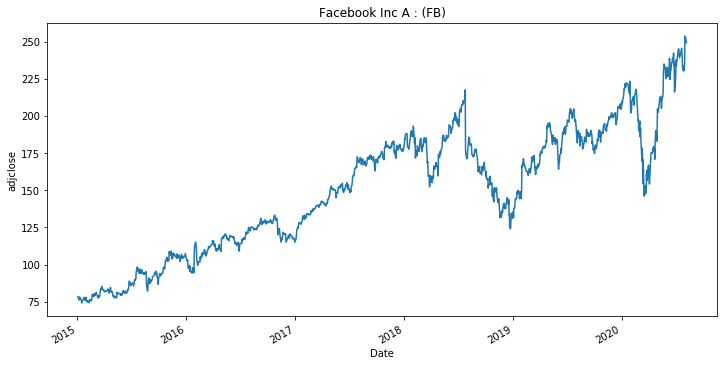

In [15]:
Title= ['Tesla Inc : (TSLA )' ,'Square Inc A : (SQ)','Roku Inc Class A : (ROKU)','2U Inc : (TWOU)','Zillow Group Inc C : (Z)','Splunk Inc : (SPLK)', 'LendingTree Inc : (TREE)','Pinterest Inc : (PINS)','Xilinx Inc : (XLNX)','Facebook Inc A : (FB)']

for k in range(len(time_series)):
    plt.figure(figsize=(12,6))
    time_series[k].plot()
    plt.xlabel('Date')
    plt.ylabel('adjclose')
    plt.title(Title[k])
    plt.show()

By analyzing the above graph of all 10 stocks it seems that all these stocks became very volatile in 2020 specially after March-2020, and the reason is due to pandemic stock market was crash very badly in March, however after that it started recovering and seen a significant rise in most of the stock prices.

## Algorithms and Techniques:

As this is a regression problem where we have to predict stock adjusted price, so I will be using regression algorithms such as 
Amazon SageMaker DeepAR forecasting algorithm and Long Short-Term Memory (LSTM) network.

As per existing study Amazon SageMaker DeepAR forecasting algorithm is very well suited for financial time series
forecasting, so I will consider this algorithm as my first preference for this stock prediction, however I will use it
after comparing it’s performance against LSTM algorithms which is a type of recurrent neural network used in deep learning because very large architectures can be successfully trained.

First step will be to get data from Yahoo Finance and perform the require preprocessing into the data, then feed
this input data to the model, and the model will return the forecast stock Adjusted Close value for next 30 days.

## Splitting Data:
We'll evaluate our model on a test set of data. For machine learning tasks like classification, we typically create train/test data by randomly splitting examples into different sets. For forecasting it's important to do this train/test split in time rather than by individual data points.

- In this project, we want to predict about a month's worth of data, and we'll set prediction_length to 30 (days).
- To create a training set of data, we'll leave out the last 30 points of each of the time series we had generated, so we'll use only the first part as training data.
- The test set contains the complete range of each time series.

In [16]:
# create truncated, training time series
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # get training series
    time_series_training = []
    
    for ts in complete_time_series:
        # truncate trailing 30 pts
        time_series_training.append(ts[:-prediction_length])
        
    return time_series_training

In [17]:
# set prediction length
prediction_length = 30 # 30 days

time_series_training = create_training_series(time_series, prediction_length)

### Training and Test Series:
We can visualize what these series look like, by plotting the train/test series on the same axis. We should see that the test series contains all of our data in a year, and a training series contains all but the last prediction_length points.

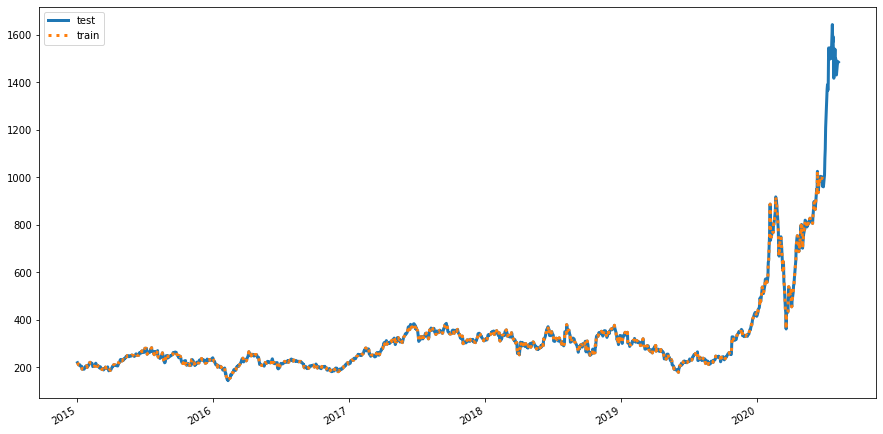

In [18]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,8))
# test data is the whole time series
time_series[time_series_idx].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

### Convert to JSON
According to the [DeepAR documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html), DeepAR expects to see input training data in a JSON format, with the following fields:

In [19]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts)}
    return json_obj

### Saving Data, Locally

In [20]:
def write_json_dataset(time_series, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for ts in time_series:
            json_line = json.dumps(series_to_json_obj(ts)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [21]:
# write train/test JSON files
write_json_dataset(time_series_training, train_key)        
write_json_dataset(time_series, test_key)

json_stock_data/train.json saved.
json_stock_data/test.json saved.


### Uploading Data to S3
Next, to make this data accessible to an estimator, I'll upload it to S3.

In [22]:
# uploading data to S3, and saving locations
train_path = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path = sagemaker_session.upload_data(test_key, bucket=bucket, key_prefix=test_prefix)

## Implementation

In [23]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


#### Instantiate an Estimator

In [24]:
# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


#### Setting Hyperparameters

In [25]:
hyperparameters = {
    'time_freq': 'D',
    'epochs': '30',
    'prediction_length': str(prediction_length),
    'context_length': str(prediction_length),
    'num_cells': '40',
    'num_layers': '3',
    'likelihood': 'gaussian',
    'learning_rate': '0.001',
    'early_stopping_patience': '10',
    'dropout_rate': '0.1'
}

In [26]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

### Training Job
we are ready to launch the training job! SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

In [27]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-08-05 20:21:30 Starting - Starting the training job...
2020-08-05 20:21:33 Starting - Launching requested ML instances......
2020-08-05 20:22:53 Starting - Preparing the instances for training.........
2020-08-05 20:24:27 Downloading - Downloading input data
2020-08-05 20:24:27 Training - Downloading the training image..Arguments: train
[08/05/2020 20:24:46 INFO 139788894787392] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[08/05/2020 20:24:4

### Deploy and Create a Predictor

We can use the trained a model to perform predictions by deploying it to a predictor endpoint.

In [28]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------------!CPU times: user 329 ms, sys: 19.1 ms, total: 349 ms
Wall time: 9min 33s


### Generating Predictions
The deployed predictor expects to see input data in a JSON format with some configuration parameters.

In [29]:
def json_predictor_input(input_ts, num_samples=50, quantiles=['0.2', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: An list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    for k in range(len(input_ts)):
        # get JSON objects for input time series
        instances.append(series_to_json_obj(input_ts[k]))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

We can use json_predictor_input function to get a prediction for a formatted time series!

In [30]:
# get all input and target (test) time series
input_ts = time_series_training
target_ts = time_series

# get formatted input time series
json_input_ts = json_predictor_input(input_ts)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

#### Decoding Predictions
The predictor returns JSON-formatted prediction, and so we need to extract the predictions and quantile data that we want for visualizing the result. The function below, reads in a JSON-formatted prediction and produces a list of predictions in each quantile.

In [31]:
# helper function to decode JSON prediction
def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list

In [32]:
# get quantiles/predictions
prediction_list = decode_prediction(json_prediction)

# should get a list of 30 predictions 
# with corresponding quantile values
print(prediction_list[0])

            0.9         0.2         0.5
0   1022.009277  922.193970  966.286499
1   1032.955688  937.136169  988.361938
2   1024.181641  921.304565  961.343628
3   1021.400757  932.827942  970.360229
4   1008.634827  928.832092  955.677979
5   1023.641479  916.637878  947.887268
6   1018.929321  911.645325  944.779907
7   1018.033630  907.188293  939.062988
8    991.924866  907.689941  942.431824
9    996.417175  864.262390  926.027527
10   999.113403  873.682861  905.543823
11   989.894836  868.250122  903.984497
12   974.839783  851.755554  895.899109
13   975.923950  854.452698  890.492615
14   953.816467  828.647461  869.866577
15   966.356018  830.316772  866.660828
16   921.705688  800.833557  849.983459
17   951.117065  813.220215  840.955627
18   935.934998  797.654236  846.630127
19   915.151367  769.424622  809.611755
20   890.186584  766.099182  801.087158
21   877.395996  764.501404  819.842957
22   889.285706  726.430847  780.913025
23   844.401123  741.016235  778.726318


#### Visualize Predictions
The quantile data will give us all we need to see the results of our prediction.

Quantiles 0.2 and 0.9 represent lower and higher bounds for the predicted values.
Quantile 0.5 represents the median of all sample predictions.

In [35]:
# display the prediction median against the actual data
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.2']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

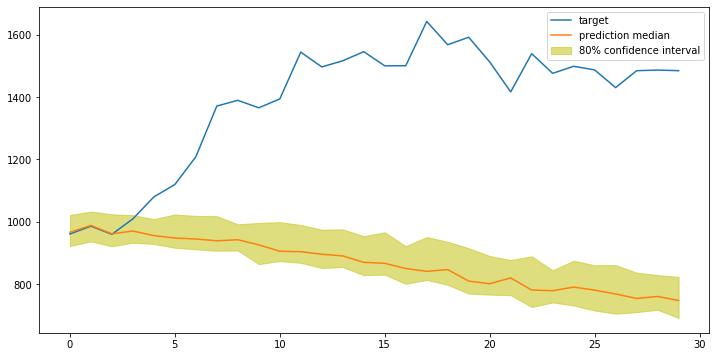

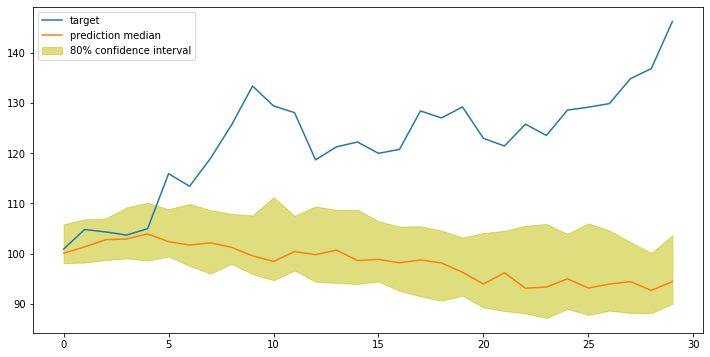

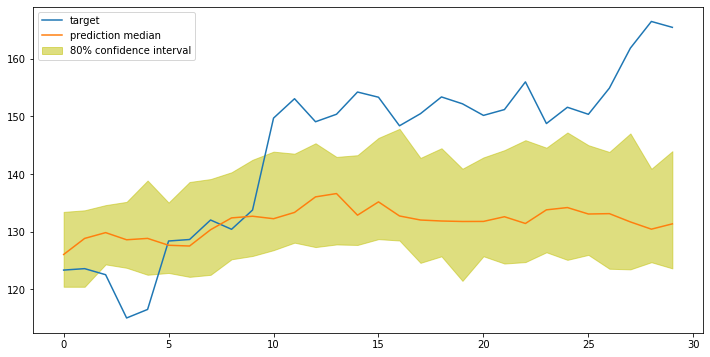

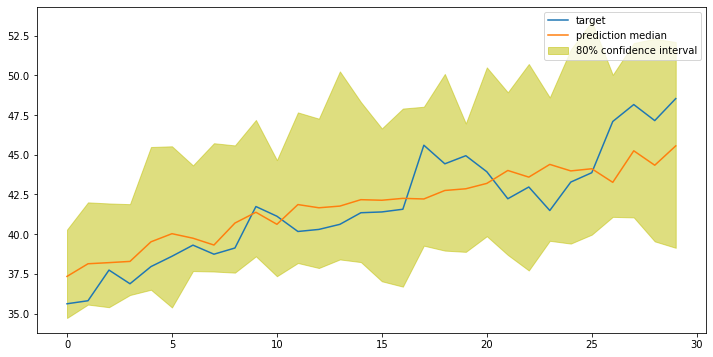

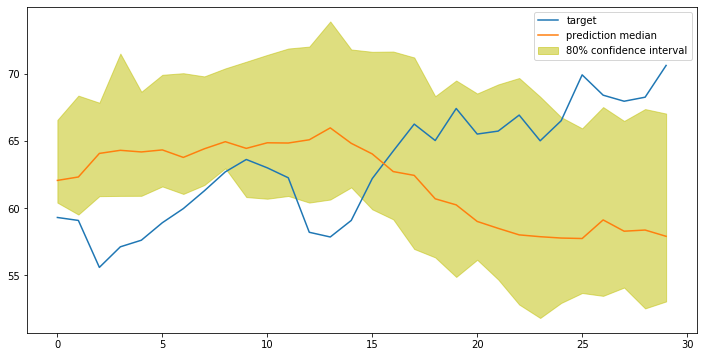

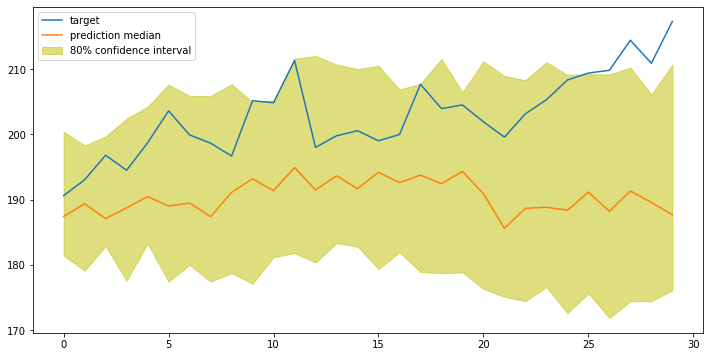

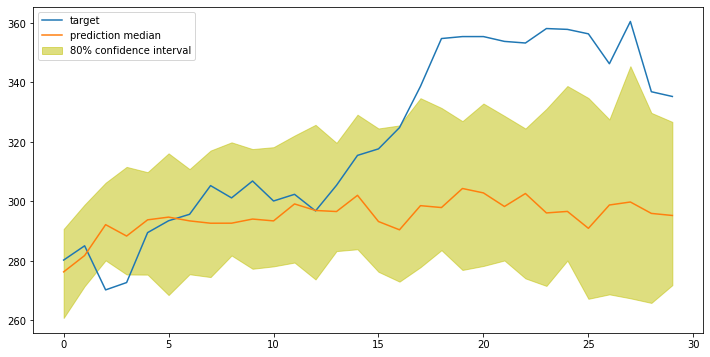

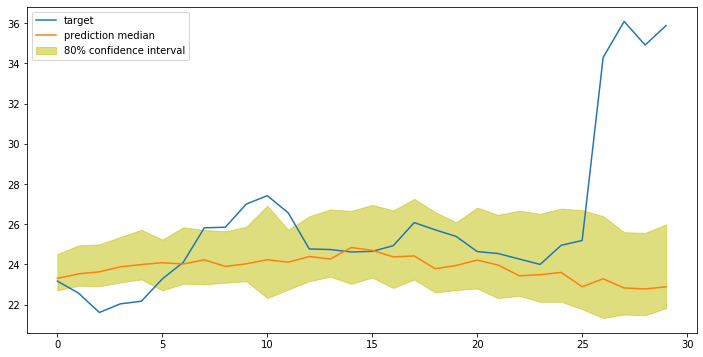

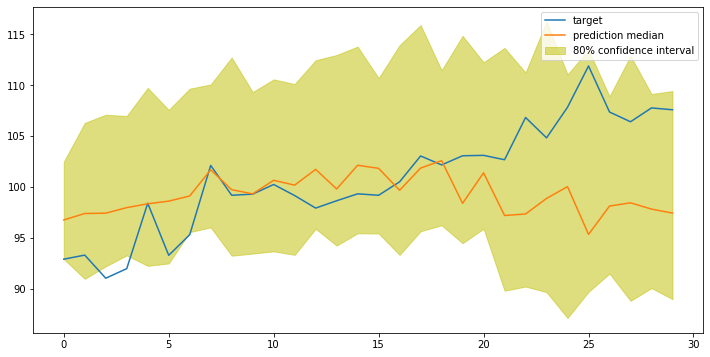

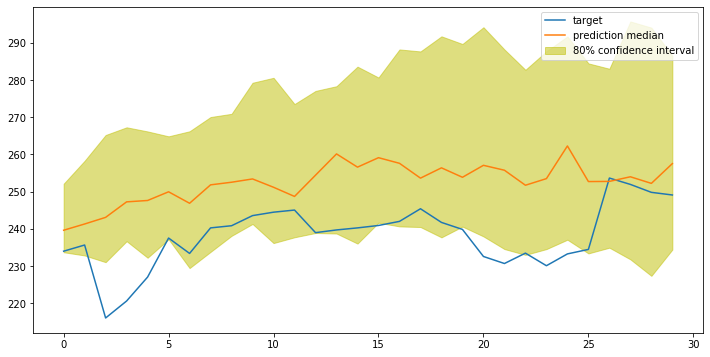

In [36]:
# display predictions
display_quantiles(prediction_list, target_ts)

From the above prediction graph of each stocks it seems our predictor did significant well for less volatile stocks like Xilinx Inc(XLNX), 2U Inc(TWOU), Splunk Inc(SPLK) and somewhat good for Facebook(FB) as well, however highly volatile stocks like Tesla Inc(TSLA ),Roku Inc Class A(ROKU) and Square Inc A(SQ) did insane market rally in terms of it's stock price in last 4 months and no one had anticipated this much price movement but people's sentiment made it insane which I feel is not possible to predict by using historical stock data and I feel social media data related to these companies would help to consider the market sentiment to make better prediction.

In [37]:
def build_series_for_comparison(prediction_list, target_ts):
    '''
    transform predictions into pandas series for comparison
    '''
    
    pred_series   = pd.Series()
    target_series = pd.Series()
    
    for k in range(len(prediction_list)):
        target = target_ts[k][-30:]
        pred   = prediction_list[k]['0.5']
        
        pred_s = pd.Series(list(pred), index=target.index)
        pred_s = pred_s[target.notnull()]
        target = target[target.notnull()]
        
        pred_series   = pred_series.append(pred_s)
        target_series = target_series.append(target)
    
    return pred_series, target_series

In [38]:
pred_series, target_series = build_series_for_comparison(prediction_list, target_ts)
print(len(pred_series), len(target_series))

300 300


/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [42]:
import math
from sklearn.metrics import mean_squared_error
Prediction_error = math.sqrt(mean_squared_error(target_series, pred_series))
print('Test RMSE: %.2f' % Prediction_error)

Test RMSE: 184.59


In [43]:
predictor.delete_endpoint()

## Refinement
The model which we have trained did not give good prediction for some of the stocks, now I will use DeepAR hyperparameter tunning to optimize this model, so that I can get better prediction results. 

In [44]:
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

estimator_tuned= Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [45]:
freq='D'
context_length = 30

hyperparameters = {
    'time_freq': 'D',
    'epochs': '30',
    'prediction_length': str(prediction_length),
    'context_length': str(prediction_length),
    'num_cells': '40',
    'num_layers': '3',
    'likelihood': 'gaussian',
    'learning_rate': '0.001',
    'early_stopping_patience': '10',
    'dropout_rate': '0.1'
}

In [46]:
estimator_tuned.set_hyperparameters(**hyperparameters)

In [52]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'learning_rate': ContinuousParameter(0.00001, 0.1),
                         'num_cells'      : IntegerParameter(50, 80),
                         'num_layers': IntegerParameter(2, 6),
                         'epochs': IntegerParameter(10, 100)}
                         
 
DeepAR_tuner = HyperparameterTuner(estimator=estimator_tuned,
                            objective_metric_name='train:final_loss',
                            hyperparameter_ranges=hyperparameter_ranges,
                            max_jobs=10,
                            max_parallel_jobs=3)
 


In [55]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

DeepAR_tuner = HyperparameterTuner(estimator = estimator_tuned, 
               objective_metric_name = 'train:final_loss', 
               objective_type = 'Minimize', 
               max_jobs = 20, 
               max_parallel_jobs = 3, 
               hyperparameter_ranges = {
                    'num_cells'      : IntegerParameter(50, 70),
                    'num_layers': IntegerParameter(2, 6),
                    'learning_rate': ContinuousParameter(1e-5, 1e-2),
               })

In [56]:
DeepAR_tuner.fit(inputs=data_channels)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [57]:
DeepAR_tuner.wait()

...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [58]:
DeepAR_tuner.best_training_job()

'forecasting-deepar-200806-0408-017-89bec845'

In [59]:
deepar_attached = sagemaker.estimator.Estimator.attach(DeepAR_tuner.best_training_job())

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-08-06 04:46:52 Starting - Preparing the instances for training
2020-08-06 04:46:52 Downloading - Downloading input data
2020-08-06 04:46:52 Training - Training image download completed. Training in progress.
2020-08-06 04:46:52 Uploading - Uploading generated training model
2020-08-06 04:46:52 Completed - Training job completedArguments: train
[08/06/2020 04:45:02 INFO 139795971041088] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[08/06/2020 

In [62]:
%%time

# create a predictor
predictor = deepar_attached.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" 
)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: forecasting-deepar-200806-0408-017-89bec845


---------------!CPU times: user 281 ms, sys: 7.78 ms, total: 289 ms
Wall time: 7min 32s


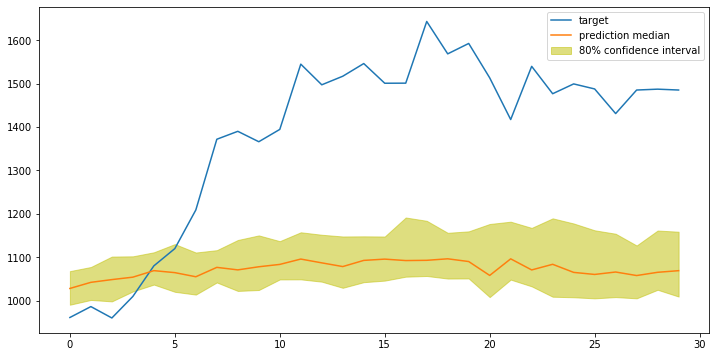

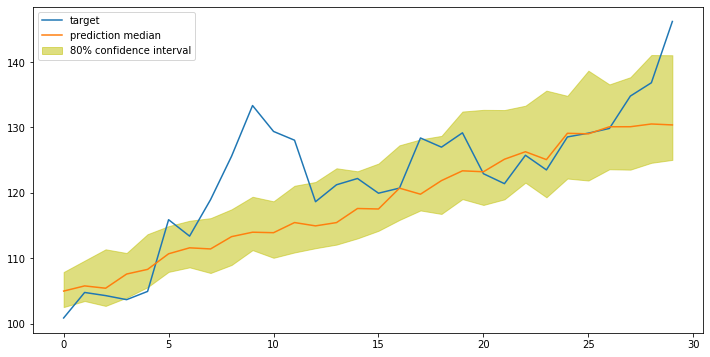

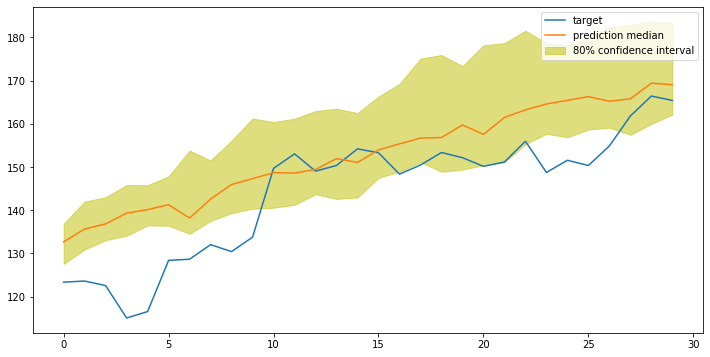

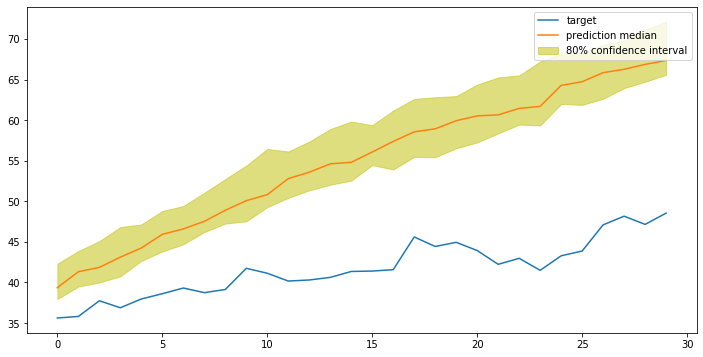

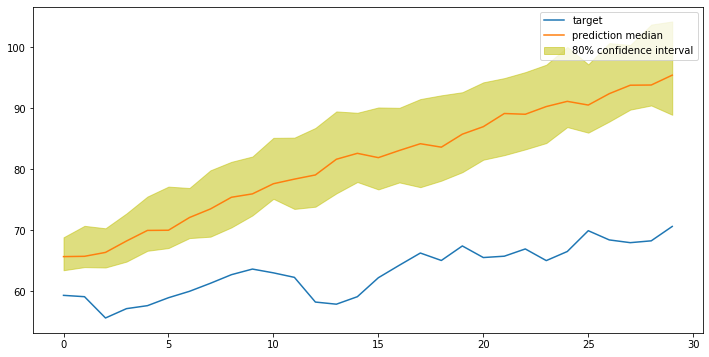

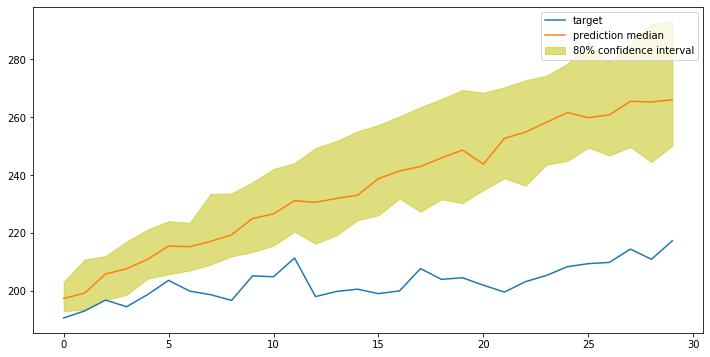

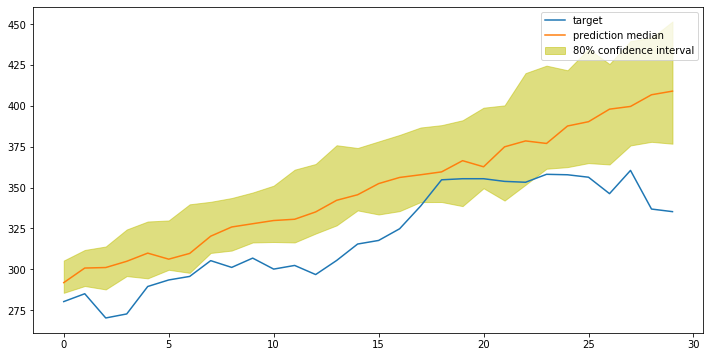

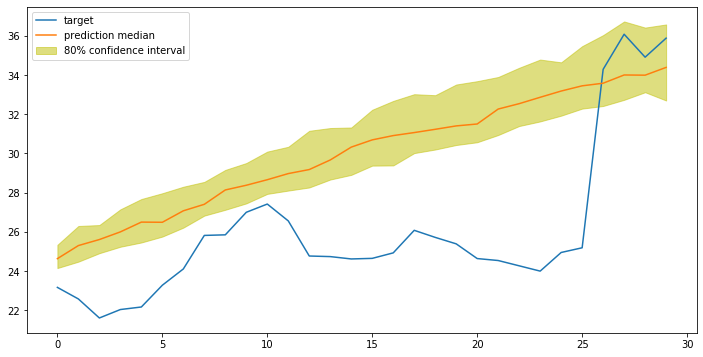

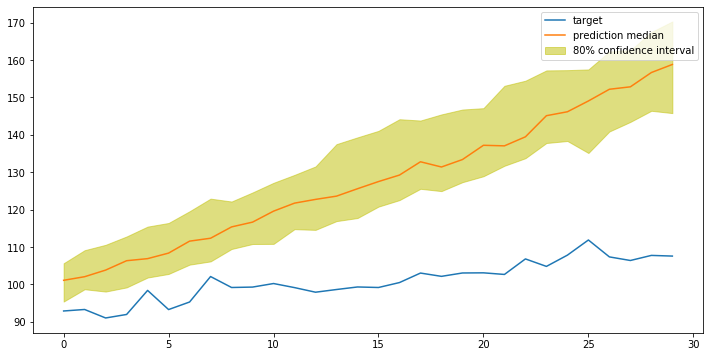

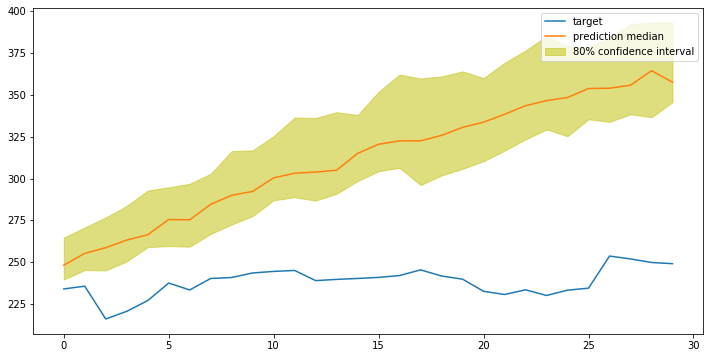

In [65]:
# get all input and target (test) time series and get prediction using the tuned model
input_ts = time_series_training
target_ts = time_series

# get formatted input time series
json_input_ts = json_predictor_input(input_ts)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)
prediction_list = decode_prediction(json_prediction)

display_quantiles(prediction_list, target_ts)

In [66]:
pred_series, target_series = build_series_for_comparison(prediction_list, target_ts)
print(len(pred_series), len(target_series))

300 300


/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [67]:
Prediction_error = math.sqrt(mean_squared_error(target_series, pred_series))
print('Test RMSE: %.2f' % Prediction_error)

Test RMSE: 120.08


## Model Evaluation and Validation
In order to validate my tuned model for it's robustness, I will take altogether a new stock Apple(AAPL) which model has not seen and will use the tuned predictor to predict it's price.

In [68]:
#Load Data for AAPL stock

start_date = '01/01/2015'
end_date = datetime.now()

start_timestamp = int(time.mktime(datetime.strptime(start_date, '%m/%d/%Y').timetuple()))
end_timestamp = int(datetime.timestamp(end_date))

data_Val = []
stock_tickers = ['AAPL']
for ticker in stock_tickers:
    data_Val.append(load_stock_data('1d', start_timestamp, end_timestamp, ticker))

In [69]:
AAPL_Stock_data = [json.loads(d.text)['prices'] for d in data_Val]

time_series_val = []
for stock in AAPL_Stock_data:
    values = []
    index = []
    for day in stock:
        if 'adjclose' in day:
            values.append(day['adjclose'])
            index.append(datetime.fromtimestamp(day['date']))
    values.reverse()
    index.reverse()
    time_series_val.append(pd.Series(data=values, index=index))
    print(len(values))


1408


In [71]:
#Split Data

prediction_length = 30

time_series_training_val = []
for ts in time_series_val:
    time_series_training_val.append(ts[:-prediction_length])

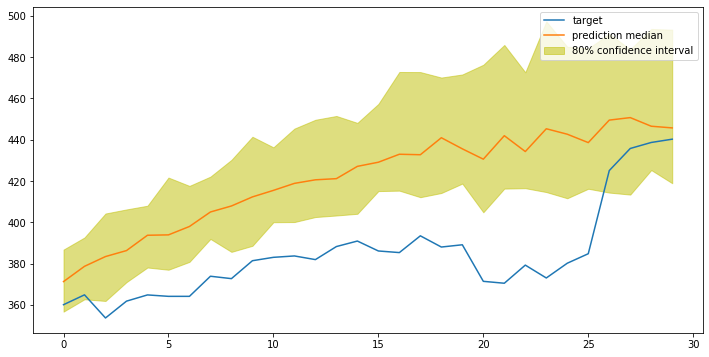

In [72]:
# get all input and target (test) time series and get prediction using the tuned model
input_ts_val = time_series_training_val
target_ts_val = time_series_val

# get formatted input time series
json_input_ts_val = json_predictor_input(input_ts_val)

# get the prediction from the predictor
json_prediction_val = predictor.predict(json_input_ts_val)
prediction_list_val = decode_prediction(json_prediction_val)

display_quantiles(prediction_list_val, target_ts_val)

In [73]:
pred_series_val, target_series_val = build_series_for_comparison(prediction_list_val, target_ts_val)
print(len(pred_series_val), len(target_series_val))

30 30


/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [74]:
Prediction_error_val = math.sqrt(mean_squared_error(target_series_val, pred_series_val))
print('Test RMSE: %.2f' % Prediction_error_val)

Test RMSE: 40.50


In [75]:
predictor.delete_endpoint()

The tuned model has worked well for a unseen Apple stock data to predict the trend for last 30 days and it is able to predict upward and downward price movement, also RMSE is a lot better in this which is 40.50.
However predicted price is going outside the confidence interval and the reason is apple had quaterly result on 30-July hence for last 30 days it was so volatile and market sentiment was driving it more, another reason was that Apple’s 4-for-1 stock split news fuels bets and that also made this stock more volatile.

I believe still this model did pretty well even in this sentiment driven market.

## Justification
### Benchmark
I will compare my final model's results with my benchmark model which is Long Short-Term Memory network(LSTM), LSTM is also very well known for time-series prediction.
I will use the same Apple stock for this benchmark model.

In [79]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [80]:
#Get the stock quote 
df = web.DataReader('AAPL', data_source='yahoo', start='2015-01-01', end='2020-08-06') 
#Show the data 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,111.440002,107.349998,111.389999,109.330002,53204600.0,99.945885
2015-01-05,108.650002,105.410004,108.290001,106.250000,64285500.0,97.130241
2015-01-06,107.430000,104.629997,106.540001,106.260002,65797100.0,97.139420
2015-01-07,108.199997,106.699997,107.199997,107.750000,40105900.0,98.501518
2015-01-08,112.150002,108.699997,109.230003,111.889999,59364500.0,102.286186
...,...,...,...,...,...,...
2020-07-30,385.190002,375.070007,376.750000,384.760010,39532500.0,384.760010
2020-07-31,425.660004,403.299988,411.540009,425.040009,93584200.0,425.040009
2020-08-03,446.549988,431.570007,432.799988,435.750000,77037800.0,435.750000


In [81]:
df.shape

(1408, 6)

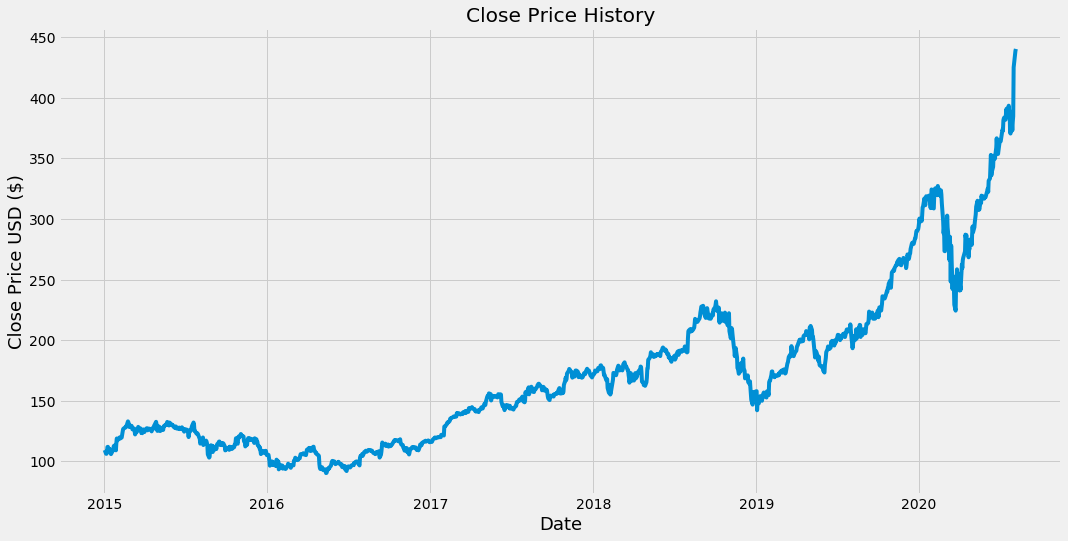

In [82]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [83]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [84]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [85]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [86]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [87]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [88]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [89]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [90]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
1067/1067 [==============================] - 107s 100ms/step - loss: 5.8245e-04


In [91]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [92]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [93]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [94]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [95]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

12.752010298065784

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


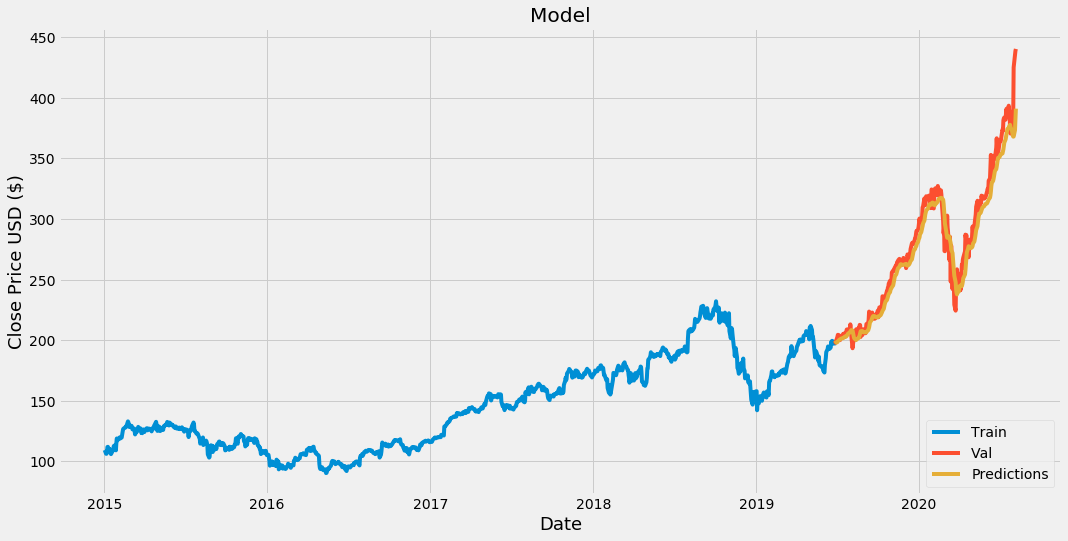

In [96]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

It seems LSTM is predicting data more accurately and RMSE value 12.75 is also significant less than the tuned deepAR model.
Also from the above graph it looks like LSTM model is able to predict upward and downward trend very effectively, and stock predicted value is very close to actual stock value.